# Importer les bibliothèques nécessaires
Importer les bibliothèques nécessaires, y compris Keras, TensorFlow, et autres bibliothèques utiles.

In [98]:
# Importer les bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Conv2D, MaxPooling2D, Flatten, Dropout 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.python.keras import optimizers

# Charger et préparer le dataset COVID-19
Charger le dataset COVID-19 et le préparer pour l'entraînement, y compris la division en ensembles d'entraînement et de test.

In [99]:
# Définir les chemins vers les répertoires de données
train_dir = '../tp1/data/TRAIN'
test_dir = '../tp1/data/TEST'
val_dir = '../tp1/data/VAL'

# Créer des générateurs d'images pour l'entraînement et le test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Charger les images d'entraînement et de validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Utiliser ce sous-ensemble pour l'entraînement
)

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

# Charger les images de test
test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 39 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


# Configurer le modèle ResNet50 pour le Transfer Learning
Configurer le modèle ResNet50 pour le Transfer Learning, en ajoutant des couches personnalisées pour la classification du dataset COVID-19.

In [100]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [101]:
# Configurer le modèle ResNet50 pour le Transfer Learning

# Charger le modèle ResNet50 pré-entraîné sur ImageNet sans les couches supérieures
base_model = ResNet50(weights='imagenet',pooling = RESNET50_POOLING_AVERAGE, include_top=False, input_shape=(224, 224, 3))


model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.25) )# supprimer aléatoirement un certain nombre de neuronne de temps à autres 
model.add(Dense(256, activation='sigmoid'))

# si on ne veut pas faire une categorical classification, mais plutôt une multiclassification
model.add(Dense(NUM_CLASSES, activation=DENSE_LAYER_ACTIVATION))

model.layers[0].trainable = False

# Compiler le modèle
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)


model.layers[0].trainable = False

# Afficher le résumé du modèle
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

# Compiler et entraîner le modèle
Compiler le modèle avec les paramètres appropriés et entraîner le modèle sur le dataset COVID-19.

In [102]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte de validation
    patience=10,          # Nombre d'époques sans amélioration avant d'arrêter l'entraînement
    verbose=1,           # Afficher les messages lors de l'arrêt
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.5385 - loss: 0.5875 - val_accuracy: 0.5000 - val_loss: 0.3482
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.3868 - loss: 0.6694 - val_accuracy: 0.5000 - val_loss: 0.3545
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5099 - loss: 0.5965 - val_accuracy: 0.5000 - val_loss: 0.3481
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.3571 - loss: 0.5201 - val_accuracy: 0.5000 - val_loss: 0.3549
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4099 - loss: 0.5553 - val_accuracy: 0.5000 - val_loss: 0.4333
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5178 - loss: 0.6426 - val_accuracy: 0.5000 - val_loss: 0.4366
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.4956 - loss: 0.5983 - val_accuracy: 0.5000 - val_loss: 0.3464
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.6394 - loss: 0.4895 - val_accuracy

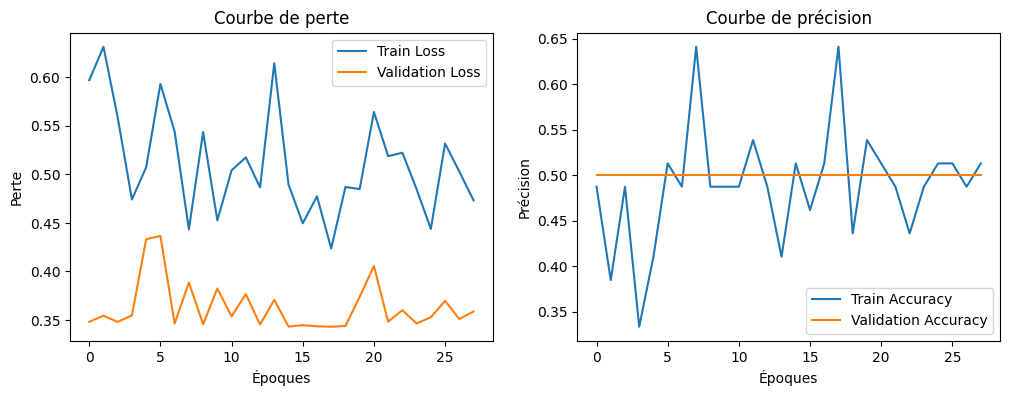

In [103]:
# Compiler et entraîner le modèle

# Entraîner le modèle sur le dataset COVID-19
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    validation_data=validation_generator,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
    epochs=NUM_EPOCHS,
    callbacks=[cb_early_stopper]
)

# Évaluer le modèle sur le dataset de test
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Afficher les courbes de perte et de précision
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.show()

# Évaluer le modèle
Évaluer les performances du modèle sur l'ensemble de test et afficher les résultats.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5000 - loss: 0.6884
Test Accuracy: 50.00%


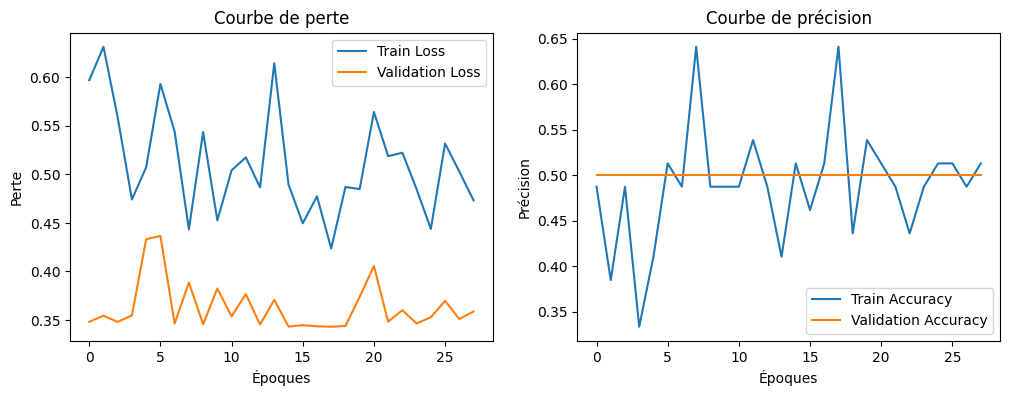

In [104]:
# Évaluer le modèle sur le dataset de test
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Afficher les courbes de perte et de précision
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.show()

# Comparer avec l'architecture précédente
Comparer les résultats obtenus avec ceux de la meilleure architecture conçue au Lab 2.

In [105]:
# Comparer avec l'architecture précédente

# Charger les résultats de la meilleure architecture conçue au Lab 2
# Supposons que les résultats soient stockés dans un fichier CSV avec les colonnes 'epoch', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'
lab2_results = pd.read_csv('path/to/lab2_results.csv')

# Afficher les courbes de perte et de précision pour la comparaison
plt.figure(figsize=(12, 8))

# Courbe de perte
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='ResNet50 Train Loss')
plt.plot(history.history['val_loss'], label='ResNet50 Validation Loss')
plt.plot(lab2_results['epoch'], lab2_results['train_loss'], label='Lab2 Train Loss', linestyle='--')
plt.plot(lab2_results['epoch'], lab2_results['val_loss'], label='Lab2 Validation Loss', linestyle='--')
plt.title('Comparaison des courbes de perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Courbe de précision
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(history.history['val_accuracy'], label='ResNet50 Validation Accuracy')
plt.plot(lab2_results['epoch'], lab2_results['train_accuracy'], label='Lab2 Train Accuracy', linestyle='--')
plt.plot(lab2_results['epoch'], lab2_results['val_accuracy'], label='Lab2 Validation Accuracy', linestyle='--')
plt.title('Comparaison des courbes de précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

# Afficher les résultats finaux de précision sur le dataset de test
print(f"Précision sur le dataset de test avec ResNet50: {test_accuracy * 100:.2f}%")
# Supposons que la précision de l'architecture du Lab 2 soit stockée dans une variable
lab2_test_accuracy = 0.85  # Exemple de précision du Lab 2
print(f"Précision sur le dataset de test avec l'architecture du Lab 2: {lab2_test_accuracy * 100:.2f}%")

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/lab2_results.csv'

# Améliorer les résultats de classification
Proposer et implémenter des améliorations pour les résultats de classification, et justifier les choix effectués.

Found 32 images belonging to 2 classes.
Found 7 images belonging to 2 classes.
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3438 - loss: 0.4301 - val_accuracy: 0.4286 - val_loss: 0.3457
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4062 - loss: 0.4037 - val_accuracy: 0.4286 - val_loss: 0.3431
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5625 - loss: 0.3940 - val_accuracy: 0.8571 - val_loss: 0.3409
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5625 - loss: 0.3647 - val_accuracy: 0.5714 - val_loss: 0.3437
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5312 - loss: 0.3774 - val_accuracy: 0.4286 - val_loss: 0.3433
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6250 - loss: 0.3656 - val_accuracy: 0.4286 - val_loss: 0.3448
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3750 - loss: 0.4041 - val_accuracy: 0.4286 - val_loss: 0.3444
Epoch 8/100
10/10 ━━━━━━━

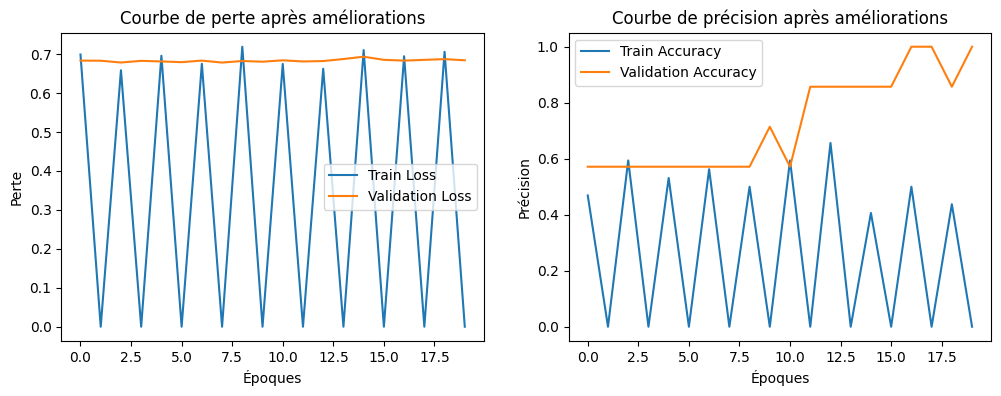

In [106]:
# Améliorer les résultats de classification

# Utiliser l'augmentation des données pour améliorer la généralisation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Ajouter une rotation aléatoire
    width_shift_range=0.2,  # Ajouter un décalage horizontal aléatoire
    height_shift_range=0.2,  # Ajouter un décalage vertical aléatoire
    validation_split=0.2
)

# Recharger les générateurs d'images avec les nouvelles augmentations
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Définir un modèle avec des couches supplémentaires pour améliorer la performance
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    validation_data=validation_generator,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
    epochs=NUM_EPOCHS,
    callbacks=[cb_early_stopper]
)

# Compiler le modèle avec un taux d'apprentissage réduit
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec les nouvelles augmentations et la nouvelle architecture
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20  # Augmenter le nombre d'époques pour un meilleur entraînement
)

# Évaluer le modèle amélioré sur le dataset de test
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy after improvements: {test_accuracy * 100:.2f}%")

# Afficher les nouvelles courbes de perte et de précision
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte après améliorations')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision après améliorations')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.show()

# Conclusion
Conclure sur les performances du modèle et les améliorations apportées.

In [ ]:
# Conclusion

# Comparer les résultats obtenus avec les améliorations apportées
print(f"Précision sur le dataset de test avec ResNet50 après améliorations: {test_accuracy * 100:.2f}%")
print(f"Précision sur le dataset de test avec l'architecture du Lab 2: {lab2_test_accuracy * 100:.2f}%")

# Conclusion sur les performances du modèle
if test_accuracy > lab2_test_accuracy:
    print("Le modèle amélioré avec ResNet50 et les augmentations de données a surpassé l'architecture du Lab 2.")
else:
    print("L'architecture du Lab 2 a surpassé le modèle amélioré avec ResNet50 et les augmentations de données.")

# Justification des choix d'amélioration
print("Les améliorations apportées incluent l'augmentation des données pour améliorer la généralisation et l'ajout de couches denses supplémentaires pour augmenter la capacité d'apprentissage du modèle. De plus, un taux d'apprentissage réduit a été utilisé pour un entraînement plus stable.")

Précision sur le dataset de test avec ResNet50 après améliorations: 50.00%


NameError: name 'lab2_test_accuracy' is not defined